# Multilevel modeling

In [ ]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)
library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [2]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]

In [3]:
head(df)

ctry,year,gdp,le,le_log,gdp_log
2020,1900,2875.352,41.14719,-0.2832005,-0.0001331202
2020,1905,3478.617,36.49913,-0.4030676,0.1903267151
2020,1910,3821.710,41.14719,-0.2832005,0.2843900144
2020,1915,3243.723,38.29062,-0.3551511,0.1204137191
2020,1920,3473.069,39.97605,-0.3120756,0.1887304573
2020,1925,3919.410,41.77955,-0.2679491,0.3096329779


## Multilevel model

In [4]:
# how many countries
length(unique(df$ctry))

[1] 19

I centered the variables to facilitate estimation. 

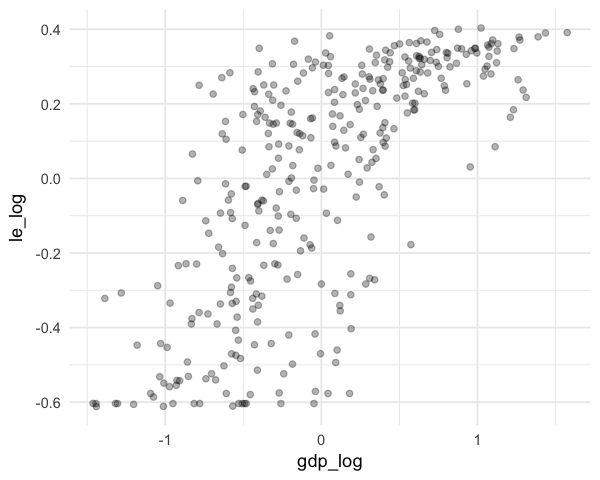

In [28]:
ggplot(df, aes(y=le_log, x=gdp_log)) + geom_point(alpha=0.3) + theme_minimal()

# Models

### Only country and year intercept random effects

In [ ]:
m1 = brm(formula = le_log ~ gdp_log + (1|ctry) + (1|year), 
    data = df)

In [7]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ gdp_log + (1 | ctry) + (1 | year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.12      0.02     0.08     0.17        628 1.00

~year (Number of levels: 23) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.33      0.05     0.24     0.46        596 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.09      0.08    -0.25     0.06        521 1.01
gdp_log       0.05      0.02     0.01     0.09       1994 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.08      0.00     0.07   

### Country and Time-varying coefficients

In [ ]:
m2 = brm(formula = le_log ~ gdp_log + (gdp_log|ctry) + (gdp_log|year), 
    data = df)

In [9]:
summary(m2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ gdp_log + (gdp_log | ctry) + (gdp_log | year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.13      0.02     0.10     0.19        648 1.01
sd(gdp_log)                0.10      0.02     0.07     0.16       1059 1.01
cor(Intercept,gdp_log)    -0.82      0.12    -0.97    -0.51       1683 1.00

~year (Number of levels: 23) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.38      0.07     0.27     0.53        636 1.01
sd(gdp_log)                0.08      0.02     0.06     0.12       1023 1.00
cor(Intercept,gdp_log)    -0.07      0.28    -0.59     0.48       

### Comparing models

In [ ]:
l1 = loo(m1)
l2 = loo(m2)

In [12]:
compare(l1, l2)

elpd_diff        se 
     73.0      16.1 

Model 2 is better!

### Plotting predictions

Predicted values using all random effectsm from model 2! GOF is not that bad. The random effects correct overfitting by shrinking extreme values towards the mean. 

In [13]:
countries = unique(df$ctry)

In [14]:
for (i in 1:length(countries)) {

    check = df[ctry==countries[i], .(ctry, year, gdp_log, le_log)]
    pred = cbind(check, predict(m2, newdata = check))
    setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

    assign(paste0('plot', i), 
           ggplot(pred, aes(x=year, y=le_log)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(-0.9, 0.6) + 
           xlim(1900, 2010) + theme_minimal()
       )

}

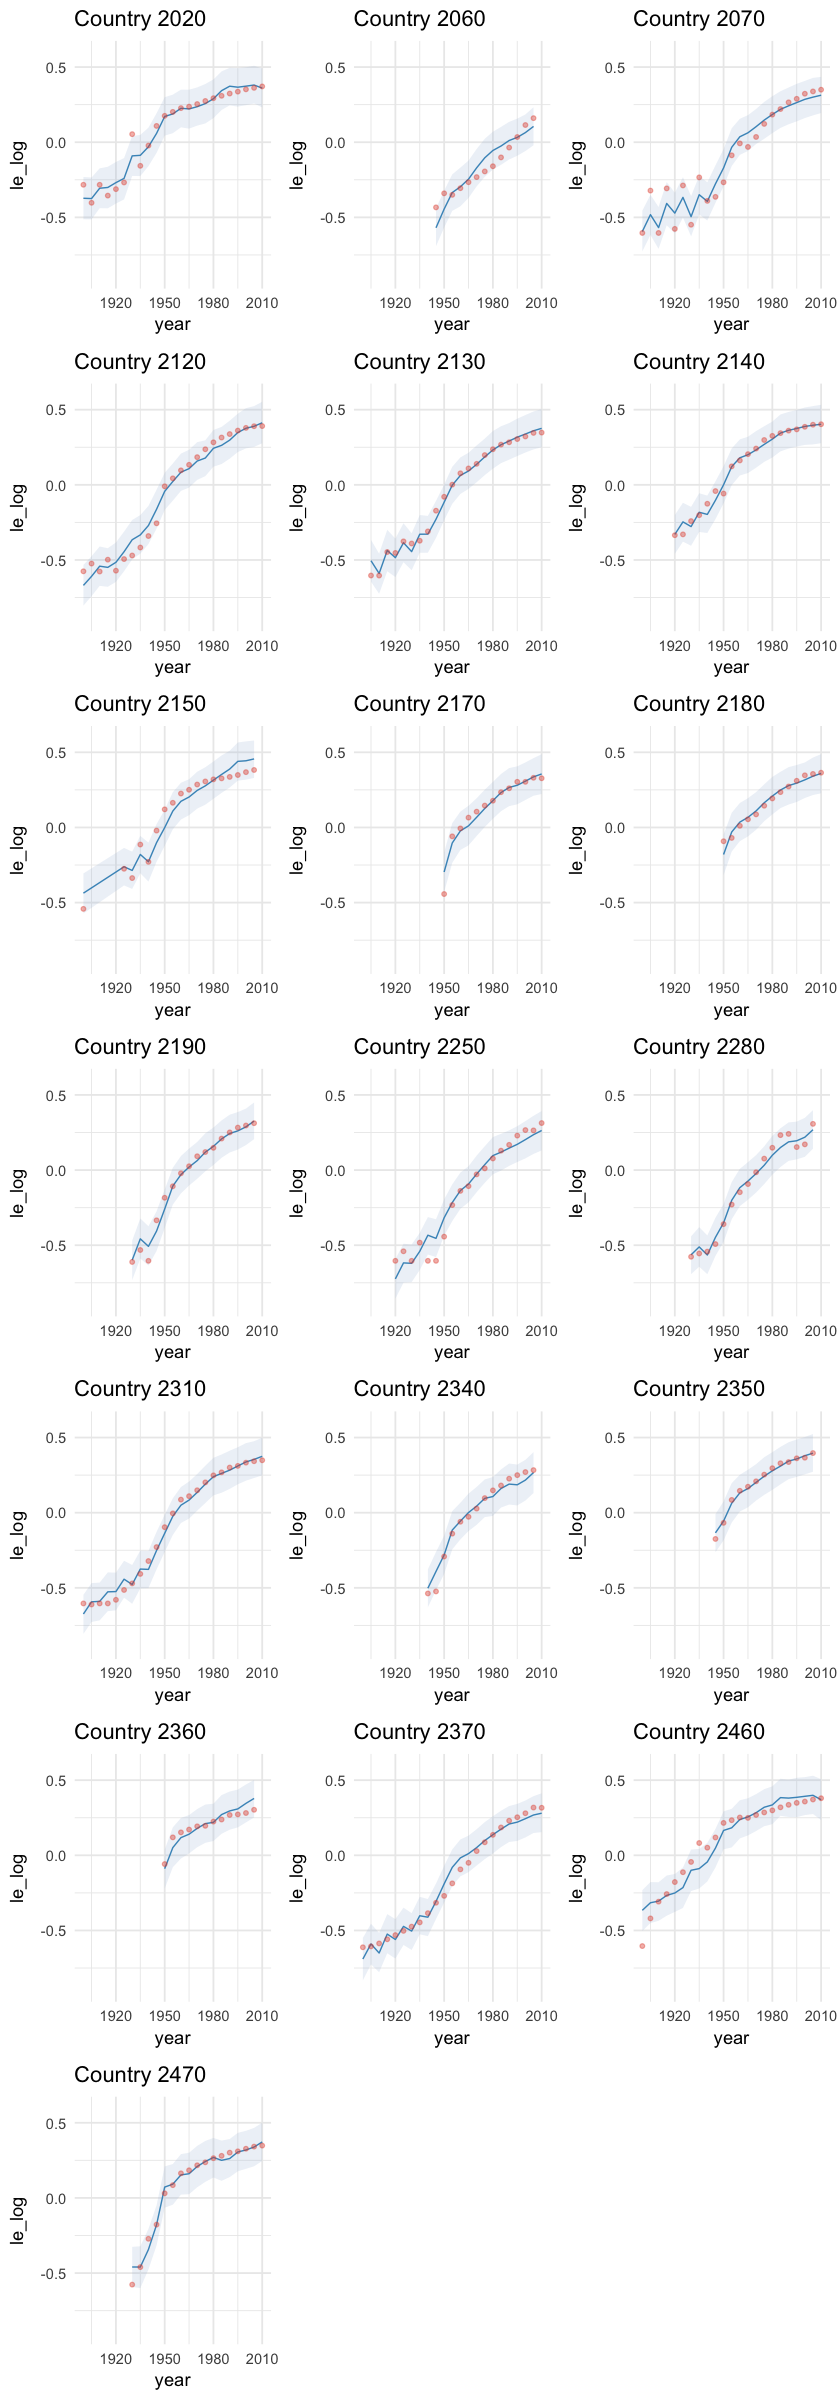

In [15]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))

# Random effects Model 2

In [16]:
re = ranef(m2) # get random effetcts

In [17]:
re_year = re$year[, c(1,3,4), 2]
re_year = data.table(year= as.numeric(rownames(re_year)), re_year)
setnames(re_year, names(re_year), c('year', 'm', 'lo', 'hi'))

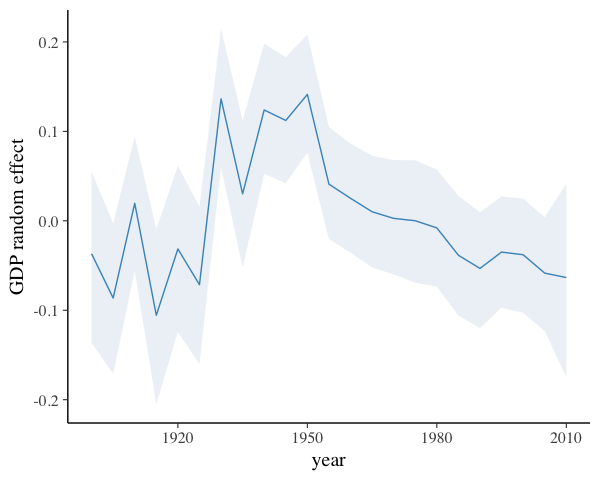

In [18]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_year, aes(x=year, y=m)) + geom_line(color='#2b8cbe', size = 0.4) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2) + 
   labs(y='GDP random effect')

In [20]:
re_ctry = re$ctry[, c(1,3,4), 2]
re_ctry = data.table(year= rownames(re_ctry), re_ctry)
setnames(re_ctry, names(re_ctry), c('country', 'm', 'lo', 'hi'))

In [21]:
setkey(re_ctry, m)

In [23]:
re_ctry[, country := as_factor(country)]

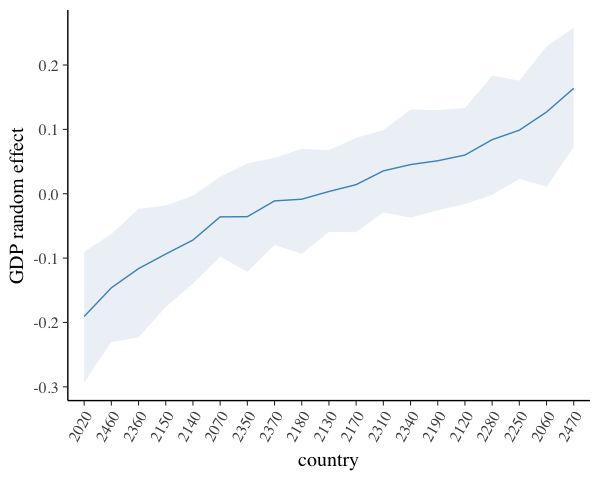

In [26]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_ctry, aes(x=country, y=m)) + 
geom_line(color='#2b8cbe', size = 0.4, group=1) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2, group=1) + 
   labs(y='GDP random effect') + 
   theme(axis.text.x = element_text(angle = 60, hjust = 1))